### Variational AutoEncoder (VAE)

A ideia desse notebook é usar o Auto encoder variacional para construção de imagens, para isso usaremos funções e classes criada por 

[fchollet](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part04_variational-autoencoders.ipynb)

Usaremos um dataset com imagens de faces, de pessoas de varias etnias, idades e gêneros.

[Dataset](https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv)



In [1]:
# importando os pacotes

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers

Como nosso Dataset é um arquivo csv, vamos usar o pandas para abri-lo.

In [2]:
df = pd.read_csv('age_gender.csv')

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


Nossa coluna de pixels é uma sequência de números

In [4]:
df.dtypes

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object

A coluna de pixels está como string, vamos então transformar para float e já fazer um reshape, assim conseguiremos visualizar nossas imagens.

In [5]:
def toPixels(pixels):
    arr = np.array(pixels.split(),"float64")
    arr = arr.reshape(48,48)
    
    return arr

df["pixels"] = df["pixels"].apply(toPixels)
pixels = np.reshape(df["pixels"].to_list(), (df.shape[0],48,48,1))

Agora temos nosso array 'pixels', formado pelas imagens do dataset que escolhemos, vamos fazer um emrabaralhento nele, pois as fotos estão separadas por idade.

In [6]:
pixels = shuffle(pixels, random_state=0)

In [7]:
pixels.shape

(23705, 48, 48, 1)

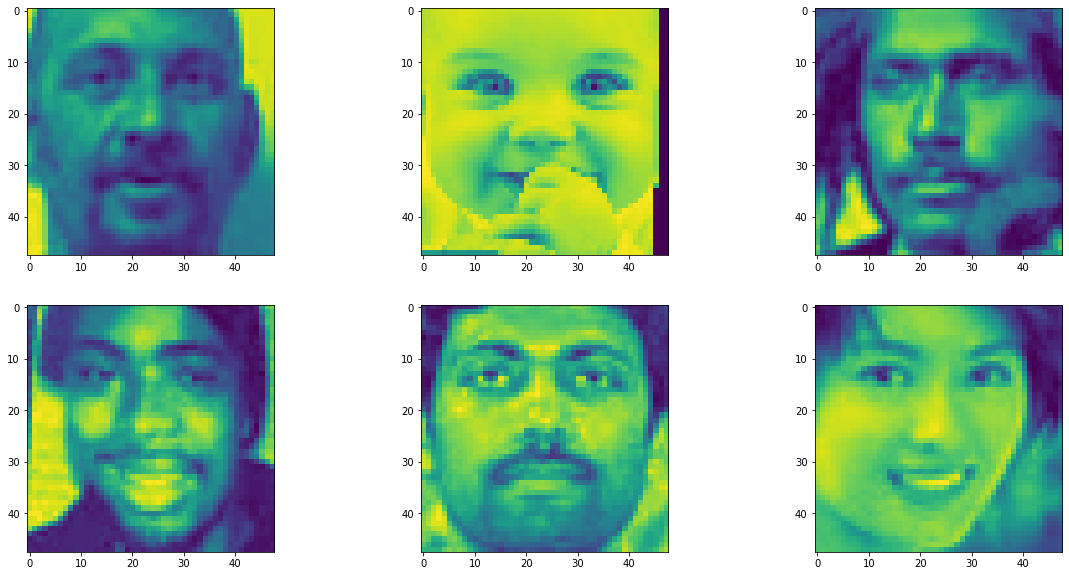

In [8]:
# vendo algumas imagens do Dataset

plt.figure(figsize = [20,10])

plt.subplot(2,3,1)
plt.imshow(pixels[0])

plt.subplot(2,3,2)
plt.imshow(pixels[1])

plt.subplot(2,3,3)
plt.imshow(pixels[100])

plt.subplot(2,3,4)
plt.imshow(pixels[1000])

plt.subplot(2,3,5)
plt.imshow(pixels[10000])

plt.subplot(2,3,6)
plt.imshow(pixels[20000])

plt.show()

Os códigos abaixo são para a construção da nossa rede neural, foram tirados do notebook do fchollet e adaptados para nosso DataSet.

In [9]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(48, 48,1))
x = layers.Conv2D(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')(encoder_inputs)
x = layers.Conv2D(filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [11]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 128)  131200      conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 18432)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4608)(latent_inputs)
x = layers.Reshape(target_shape=(6, 6, 128), input_shape=(None, 1024))(x)
x = layers.Conv2DTranspose(filters=256, kernel_size=4, strides = 4,activation=tf.nn.relu, padding='same')(x)
x = layers.Conv2DTranspose(filters=32 , kernel_size=4, strides = 2, activation=tf.nn.relu, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1,3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [13]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4608)              13824     
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 256)       524544    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 48, 48, 32)        131104    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 48, 48, 1)         289       
Total params: 669,761
Trainable params: 669,761
Non-trainable params: 0
_____________________________________________________

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Para termos uma ideia, vamos treinar apenas por 5 épocas, e depois ver os resultados obtidos com a reconstrução do autoencoder.

In [15]:
# normalizando os dados para evitar problemas.

pixels = pixels.astype("float32") / 255

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pixels, epochs=5, batch_size=248, verbose=1)

Epoch 1/5
96/96 [==============================] - 239s 2s/step - loss: 1572.6135 - reconstruction_loss: 1547.7513 - kl_loss: 3.6679
Epoch 2/5
96/96 [==============================] - 253s 3s/step - loss: 1506.4366 - reconstruction_loss: 1500.1661 - kl_loss: 3.5273
Epoch 3/5
96/96 [==============================] - 250s 3s/step - loss: 1490.5614 - reconstruction_loss: 1477.2030 - kl_loss: 5.0106
Epoch 4/5
96/96 [==============================] - 249s 3s/step - loss: 1472.5919 - reconstruction_loss: 1466.8296 - kl_loss: 5.0526
Epoch 5/5
96/96 [==============================] - 247s 3s/step - loss: 1469.7378 - reconstruction_loss: 1465.8153 - kl_loss: 4.9760


Infelizmente não conseguimos um erro de reconstrução tão baixo, mas ainda sim vamos ter bons resultados, vamos analisar como ficaram algumas reconstruções:


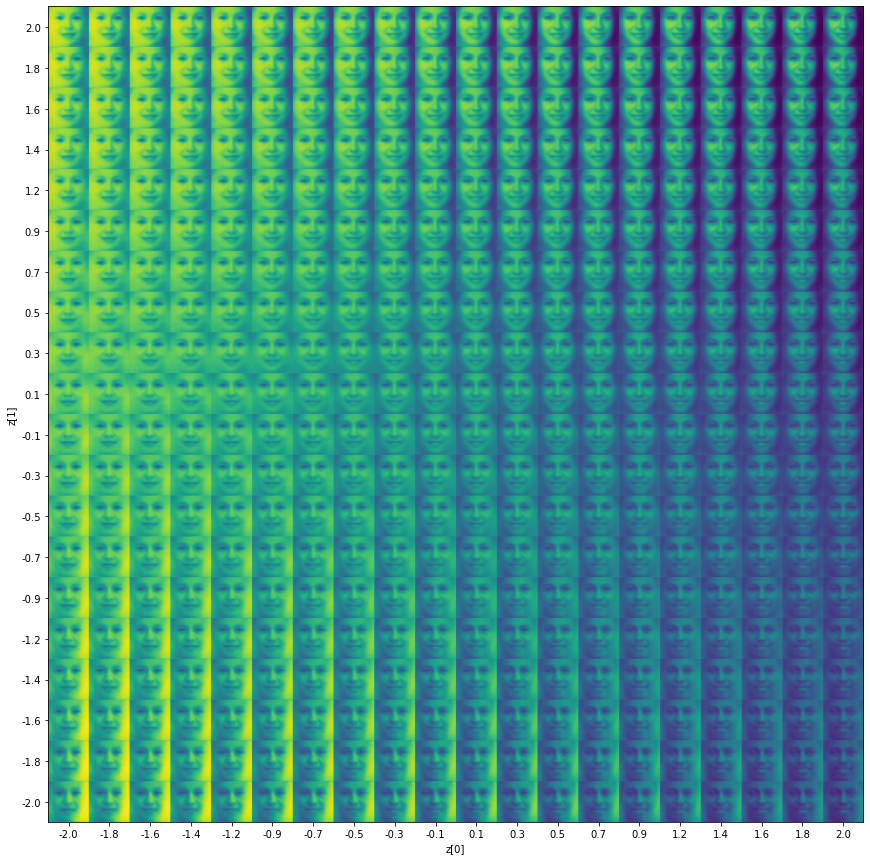

In [18]:
def plot_latent_space(vae, n=20, figsize=15):
    digit_size = 48
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n,1))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

### Temos um resultado muito bom! 

Mesmo com o erro acima de 1000, o algoritmo conseguiu reconstruir rostos de todas as etnias, idades e gêneros.

Vamos pegar alguns resultados em particular:



In [26]:
exemplos = [[-1,-1],[0,0],[2,2],[2,-2]]

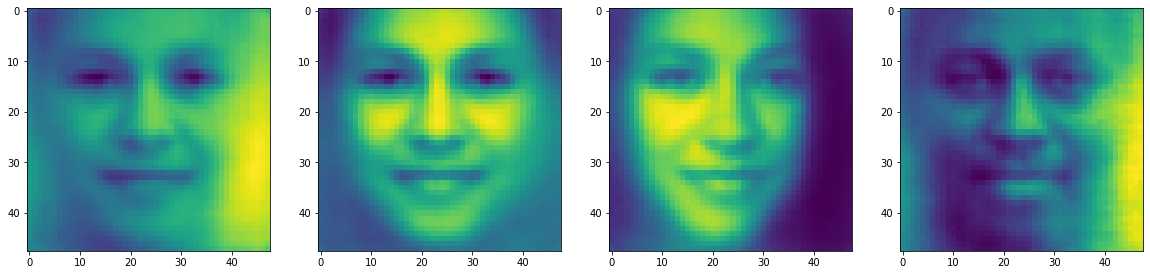

In [27]:
plt.figure(figsize = [20,10])

plt.subplot(1,4,1)
plt.imshow(vae.decoder.predict(exemplos)[0])

plt.subplot(1,4,2)
plt.imshow(vae.decoder.predict(exemplos)[1])

plt.subplot(1,4,3)
plt.imshow(vae.decoder.predict(exemplos)[2])

plt.subplot(1,4,4)
plt.imshow(vae.decoder.predict(exemplos)[3])

plt.show()

Finalizamos aqui nosso notebook, em um treinamento de 20 minutos em um notebook caseiro, o algoritmo já foi capaz de aprender a construir algumas faces, variando etnia, cor e idade.